In [1]:
import os
os.chdir('/data/1122/SGFN')
import sgfn


/root/anaconda3/envs/graphst/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import scanpy as sc
#from GraphST import GraphST
dataset = 'human_brain_metastasis'

In [ ]:
# read data
file_fold = '/data/Data1/Data/' + str(dataset) #please replace 'file_fold' with the download path
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)

adata.var_names_make_unique()

/root/anaconda3/envs/graphst/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
adata

AnnData object with n_obs × n_vars = 2152 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [ ]:
# read scRNA daa
file_path = '/data/Data1/Data/human_brain_metastasis/SC_AnnData.h5ad' # Please replace 'file_path' with the scRNA download path.
adata_sc = sc.read(file_path)
adata_sc.var_names_make_unique()

In [6]:
import preprocess

Pre-processing for ST data

In [7]:
# preprocessing for ST data
adata, adata_sc = preprocess.preprocess_(adata, adata_sc)

preprocess.construct_interaction(adata)
preprocess.add_contrastive_label(adata)


/root/anaconda3/envs/graphst/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/root/anaconda3/envs/graphst/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Reading reference data

Pre-processing for reference data

In [8]:
adata_sc

AnnData object with n_obs × n_vars = 33837 × 9967
    obs: 'cell_name', 'cell_type', 'source', 'cnv_leiden', 'cnv_score', 'cnv_status', 'cell_type_final'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

Finding overlap genes between ST and reference data

In [9]:
# find overlap genes
from preprocess import filter_with_overlap_gene
adata, adata_sc = filter_with_overlap_gene(adata, adata_sc)

Number of overlap genes: 9967


/root/anaconda3/envs/graphst/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Extracting features for ST data

In [10]:
# get features
preprocess.get_feature(adata)

Implementing GraphST for cell type deconvolution

Building sparse matrix ...


/data/1122/SGFN/preprocess.py:175: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


Begin to train ST data ...


Training Progress: 100%|██████████| 1200/1200 [00:22<00:00, 53.28it/s]


Optimization finished for ST data!


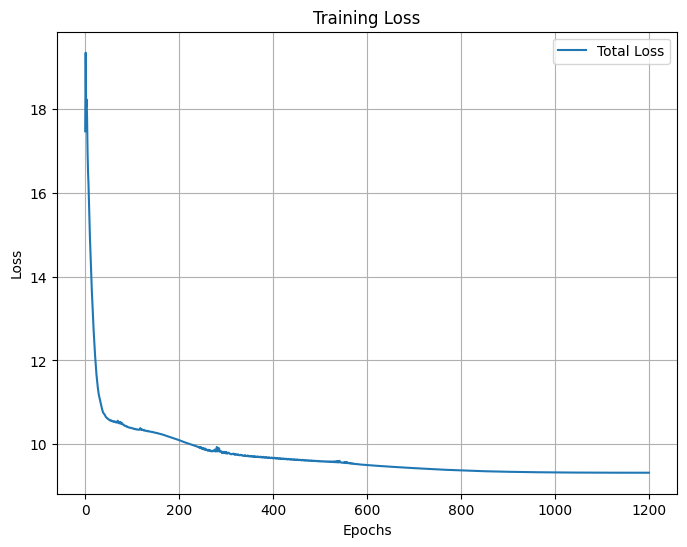


====== TRAINING PERFORMANCE SUMMARY ======
Total training time: 23.08 seconds
Memory used: 846.19 MB
GPU memory: 0.00 MB allocated, 0.00 MB reserved

Begin to train scRNA data...


100%|██████████| 1200/1200 [01:22<00:00, 14.53it/s]


Optimization finished for cell representation learning!

====== SC TRAINING PERFORMANCE SUMMARY ======
Total SC training time: 82.68 seconds
Memory used: 18.45 MB
GPU memory: 0.00 MB allocated, 0.00 MB reserved

Begin to learn mapping matrix...


100%|██████████| 1200/1200 [03:15<00:00,  6.13it/s]


Mapping matrix learning finished!


In [11]:
import torch
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# Train model
model = sgfn.SGFN(adata, adata_sc, epochs=1200, random_seed=50, device=device, deconvolution=True)
adata, adata_sc = model.train_map()

Visualization of single cell data distribution in ST tissue

In [12]:
# Project cells into spatial space
from utils import project_cell_to_spot
pre=project_cell_to_spot(adata, adata_sc,celltype_key='cell_type', retain_percent=0.15)

In [13]:
pre

,B-Lym,CD4+ T,DC,GC B-LZ,Mac-M2,Macrophage,Monocyte,T-Cyt,T-EM,T-Lym,other
AAACAACGAATAGTTC-1,0.000295,0.000000,0.000295,0.156378,0.011230,0.534360,0.009153,0.000885,0.174986,0.000295,0.112122
AAACAATCTACTAGCA-1,0.000887,0.000000,0.000589,0.128275,0.008274,0.592139,0.015073,0.000295,0.125899,0.000591,0.127978
AAACACCAATAACTGC-1,0.022772,0.094717,0.019210,0.064641,0.020081,0.221663,0.046373,0.275264,0.092989,0.128123,0.014168
AAACAGCTTTCAGAAG-1,0.028640,0.141716,0.019746,0.027392,0.009724,0.068923,0.023588,0.421887,0.039482,0.200916,0.017986
AAACAGGGTCTATATT-1,0.028359,0.142341,0.017703,0.030057,0.012678,0.081924,0.034499,0.400622,0.040086,0.193154,0.018578
...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.003251,0.000885,0.008565,0.126492,0.015667,0.541221,0.050842,0.005315,0.167633,0.005904,0.074226
TTGTTTCACATCCAGG-1,0.008277,0.028076,0.016849,0.114694,0.021284,0.463210,0.049074,0.068256,0.141894,0.038420,0.049966
TTGTTTCATTAGTCTA-1,0.018043,0.081679,0.016845,0.079446,0.014184,0.261363,0.051128,0.222227,0.115200,0.110943,0.028943
TTGTTTCCATACAACT-1,0.010940,0.028665,0.013892,0.109375,0.017444,0.437164,0.054695,0.086589,0.151669,0.045515,0.044053


In [14]:
adata

AnnData object with n_obs × n_vars = 2152 × 9967
    obs: 'in_tissue', 'array_row', 'array_col', 'B-Lym', 'CD4+ T', 'DC', 'GC B-LZ', 'Mac-M2', 'Macrophage', 'Monocyte', 'T-Cyt', 'T-EM', 'T-Lym', 'other'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'overlap_genes'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb_sp', 'map_matrix'

In [15]:
import scanpy as sc
adata_=adata.copy()

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
import networkx as nx
from scipy.spatial import distance
from scipy.stats import spearmanr
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import networkx as nx
import numpy as np
def spatial_analysis(adata):
    
    
    def composition_analysis(adata):
        """
        Create a circular visualization of cell type composition
        """
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Calculate the proportion of each cell type
        cell_types = ['B-Lym', 'CD4+ T', 'DC', 'GC B-LZ', 'Mac-M2', 
                    'Macrophage', 'Monocyte', 'T-Cyt', 'T-EM', 'T-Lym', 'other']
        proportions = adata.obs[cell_types].mean()
      
        colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974',
                '#64B5CD', '#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']
        
        plt.style.use('seaborn-white')
        fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
        
        wedges, texts, autotexts = ax.pie(proportions, 
                                        colors=colors,
                                        autopct='%1.1f%%',
                                        pctdistance=0.85,
                                        wedgeprops=dict(width=0.5, 
                                                        edgecolor='white',
                                                        linewidth=2))
        
        plt.setp(autotexts, size=12, weight="bold")
      
        legend_elements = [plt.Rectangle((0, 0), 1, 1, facecolor=color) 
                        for color in colors]
        legend_labels = [f'{cell_type}\n({proportion:.1%})' 
                        for cell_type, proportion in zip(cell_types, proportions)]
        
        ax.legend(legend_elements, 
                legend_labels,
                loc='center',
                bbox_to_anchor=(1.0, 0.5),
                frameon=False)
        
     
        plt.title('Cell Type Composition', 
                pad=16, 
                size=14)
        
    
        circle = plt.Circle((0, 0), 0.7, fc='white')
        ax.add_artist(circle)
        
 
        total_cells = int(len(adata))
        plt.text(0, 0, f'Total\n{total_cells:,}\nCells',
                ha='center',
                va='center',
                size=14
                )
        
    
        plt.tight_layout()
        
  
        plt.savefig('/data/Data1/Data/human_brain_metastasis/result/cell_composition.pdf',
                    bbox_inches='tight',
                    dpi=300)
       
        
        return proportions
    # 2. Spatial correlation analysis
    def spatial_correlation(adata):
        cell_types = ['B-Lym', 'CD4+ T', 'DC', 'GC B-LZ', 'Mac-M2', 
                     'Macrophage', 'Monocyte', 'T-Cyt', 'T-EM', 'T-Lym', 'other']
     
        corr_matrix = adata.obs[cell_types].corr(method='spearman')
       
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)
        plt.title('Cell Type Spatial Correlation')
        plt.tight_layout()
        plt.savefig('/data/Data1/Data/human_brain_metastasis/result/spatial_correlation.pdf')
        
        return corr_matrix

    # 3. Spatial Aggregation Analysis
    def spatial_clustering(adata):
      
        spatial_coords = adata.obsm['spatial']
        dist_matrix = distance.pdist(spatial_coords)
        dist_matrix = distance.squareform(dist_matrix)
        
       
        def calculate_moran_i(values, dist_matrix):
           
            weights_matrix = 1 / (dist_matrix + 1e-10)
            np.fill_diagonal(weights_matrix, 0)
            
            n = len(values)
            mean = np.mean(values)
            numerator = 0
            denominator = 0
            
            for i in range(n):
                for j in range(n):
                    numerator += weights_matrix[i,j] * (values[i] - mean) * (values[j] - mean)
                denominator += (values[i] - mean) ** 2
                
            return (n / np.sum(weights_matrix)) * (numerator / denominator)
        
        # Calculate Moran's I for each cell type
        cell_types = ['B-Lym', 'CD4+ T', 'DC', 'GC B-LZ', 'Mac-M2', 
                     'Macrophage', 'Monocyte', 'T-Cyt', 'T-EM', 'T-Lym']
        
        spatial_indices = {}
        for ct in cell_types:
            values = adata.obs[ct].values
            moran_i = calculate_moran_i(values, dist_matrix)
            spatial_indices[ct] = moran_i
   
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.flatten()
        
        for i, ct in enumerate(cell_types):
            sc.pl.spatial(adata, color=ct, show=False, ax=axes[i], title=ct,size=1.5)
        
        plt.tight_layout()
        plt.savefig('/data/Data1/Data/human_brain_metastasis/result/spatial_distribution.pdf')
        
        return spatial_indices
    def interaction_analysis(adata):
        
        import matplotlib.pyplot as plt
        import matplotlib.colors as mcolors
        from matplotlib.lines import Line2D
        import networkx as nx
        import numpy as np
        
        cell_types = ['B-Lym', 'CD4+ T', 'DC', 'GC B-LZ', 'Mac-M2', 
                    'Macrophage', 'Monocyte', 'T-Cyt', 'T-EM', 'T-Lym']
        

        cell_colors = {
            'B-Lym': '#1F77B4',      
            'CD4+ T': '#D62728',     
            'DC': '#2CA02C',         
            'GC B-LZ': '#FF7F0E',    
            'Mac-M2': '#9467BD',     
            'Macrophage': '#8C564B', 
            'Monocyte': '#E377C2',   
            'T-Cyt': '#7F7F7F',      
            'T-EM': '#BCBD22',       
            'T-Lym': '#17BECF'       
        }
        
        # Calculate the spatial interaction strength between cell types
        interaction_matrix = np.zeros((len(cell_types), len(cell_types)))
        
        for i, ct1 in enumerate(cell_types):
            for j, ct2 in enumerate(cell_types):
                if i < j:
                    score = np.sum(adata.obs[ct1] * adata.obs[ct2]) / \
                        (np.sum(adata.obs[ct1]) * np.sum(adata.obs[ct2]))
                    interaction_matrix[i,j] = score
                    interaction_matrix[j,i] = score
    
        plt.style.use('seaborn-whitegrid')
        fig = plt.figure(figsize=(8, 5))
        fig.patch.set_facecolor('white')
        
      
        G = nx.Graph()
       
        for ct in cell_types:
            G.add_node(ct)
        
        weight_threshold = np.mean(interaction_matrix)
      
        edge_weights = []
        for i, ct1 in enumerate(cell_types):
            for j, ct2 in enumerate(cell_types):
                if i < j and interaction_matrix[i,j] > weight_threshold:
                    G.add_edge(ct1, ct2, weight=interaction_matrix[i,j])
                    edge_weights.append(interaction_matrix[i,j])
       
        pos = nx.spring_layout(G, k=1.3, iterations=50)
        
        plt.clf()
        ax = plt.gca()
        ax.set_facecolor('white')
        
      
        max_weight = max(edge_weights)
        min_weight = min(edge_weights)
        edge_width_range = (2, 8)
        
        for (node1, node2, weight) in G.edges(data='weight'):
            
            width = ((weight - min_weight) / (max_weight - min_weight) * 
                    (edge_width_range[1] - edge_width_range[0]) + 
                    edge_width_range[0])
            
       
            color1 = np.array(mcolors.to_rgb(cell_colors[node1]))
            color2 = np.array(mcolors.to_rgb(cell_colors[node2]))
            edge_color = tuple((color1 + color2) / 2)
          
            nx.draw_networkx_edges(G, pos,
                                edgelist=[(node1, node2)],
                                edge_color=[edge_color],
                                width=width,
                                alpha=0.7)
       
        node_colors = [cell_colors[node] for node in G.nodes()]
        nx.draw_networkx_nodes(G, pos,
                            node_color=node_colors,
                            node_size=2500,
                            alpha=0.9,
                            linewidths=0)

        label_pos = {node: (coord[0], coord[1] - 0.02) for node, coord in pos.items()}
        for node, (x, y) in label_pos.items():
            plt.text(x, y, node,
                    fontsize=10,
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    bbox=dict(facecolor='white',
                            edgecolor='none',
                            alpha=0.7,
                            pad=0.5))
   
        plt.axis('off')
        
     
        plt.title('Cell Type Interaction Network', 
                pad=20, 
                fontsize=14,
                )
        
    
        legend_elements = []
  
        for ct in cell_types:
            legend_elements.append(plt.Line2D([0], [0],
                                            marker='o',
                                            color='w',
                                            markerfacecolor=cell_colors[ct],
                                            markersize=15,
                                            label=ct,
                                            alpha=0.9))
  
        legend_elements.extend([
            Line2D([0], [0], color='gray', linewidth=edge_width_range[0],
                label='Weak interaction'),
            Line2D([0], [0], color='gray', linewidth=edge_width_range[1],
                label='Strong interaction')
        ])
        
        plt.legend(handles=legend_elements,
                title='Cell Types and Interactions',
                loc='center left',
                bbox_to_anchor=(1.1, 0.5),
                frameon=False,
                title_fontsize=12,
                fontsize=10)
        
        plt.tight_layout()
     
        plt.savefig('/data/Data1/Data/human_brain_metastasis/result/interaction_network.pdf',
                    bbox_inches='tight',
                    dpi=300,
                    facecolor='white')
        
        return interaction_matrix
    

    # 5. patial Heterogeneity Analysis
    def heterogeneity_analysis(adata):
        
        def calculate_local_entropy(proportions):
            entropy = -np.sum(proportions * np.log2(proportions + 1e-10))
            return entropy
        
        cell_types = ['B-Lym', 'CD4+ T', 'DC', 'GC B-LZ', 'Mac-M2', 
                     'Macrophage', 'Monocyte', 'T-Cyt', 'T-EM', 'T-Lym']
        
     
        local_entropy = []
        for idx in range(len(adata)):
            props = adata.obs.iloc[idx][cell_types].values
            props = props / np.sum(props)
            local_entropy.append(calculate_local_entropy(props))
        
        adata.obs['entropy'] = local_entropy
     
        plt.figure(figsize=(10, 8))
        sc.pl.spatial(adata, color='entropy', 
                     title='Spatial Heterogeneity',size=1.5)
        plt.savefig('/data/Data1/Data/human_brain_metastasis/result/spatial_heterogeneity.pdf')
        
        return np.mean(local_entropy), np.std(local_entropy)

    results = {
        'composition': composition_analysis(adata),
        'correlation': spatial_correlation(adata),
        'clustering': spatial_clustering(adata),
        'interaction': interaction_analysis(adata),
        'heterogeneity': heterogeneity_analysis(adata)
    }
    
    return results


def save_results(results, output_file='analysis_results.txt'):
    with open(output_file, 'w') as f:
     
        f.write('Cell Type Composition:\n')
        f.write(str(results['composition']) + '\n\n')
        
  
        f.write('Spatial Correlation:\n')
        f.write(str(results['correlation']) + '\n\n')
        
      
        f.write('Spatial Clustering Indices:\n')
        f.write(str(results['clustering']) + '\n\n')
        

        f.write('Cell Type Interactions:\n')
        f.write(str(results['interaction']) + '\n\n')

        f.write('Spatial Heterogeneity:\n')
        f.write(f'Mean entropy: {results["heterogeneity"][0]}\n')
        f.write(f'Std entropy: {results["heterogeneity"][1]}\n')


/tmp/ipykernel_13131/778154726.py:55: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
/tmp/ipykernel_13131/778154726.py:212: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


TypeError: loop of ufunc does not support argument 0 of type numpy.float64 which has no callable log2 method

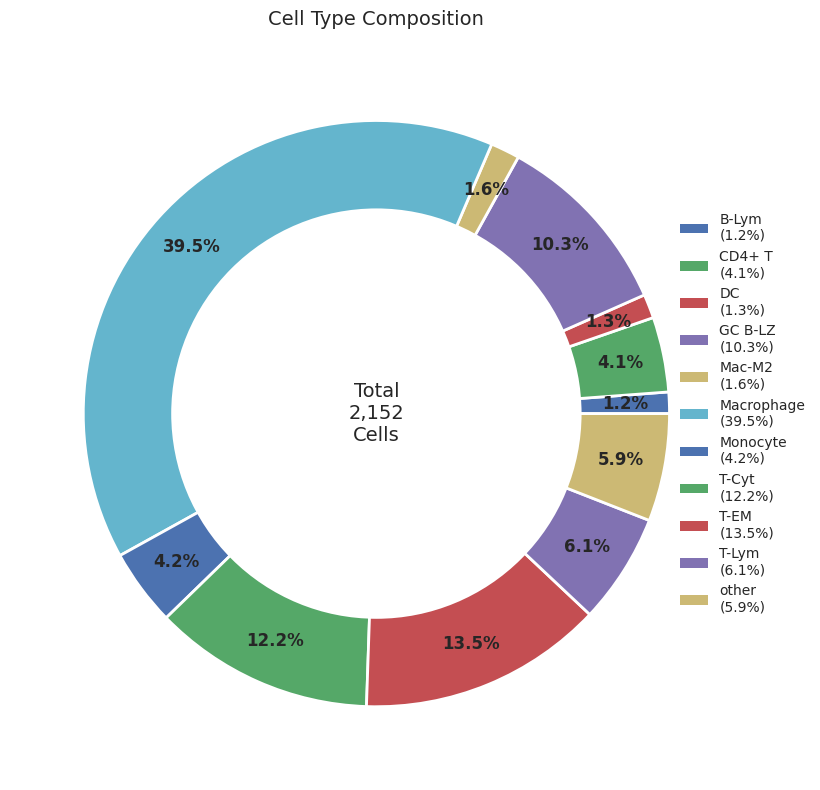

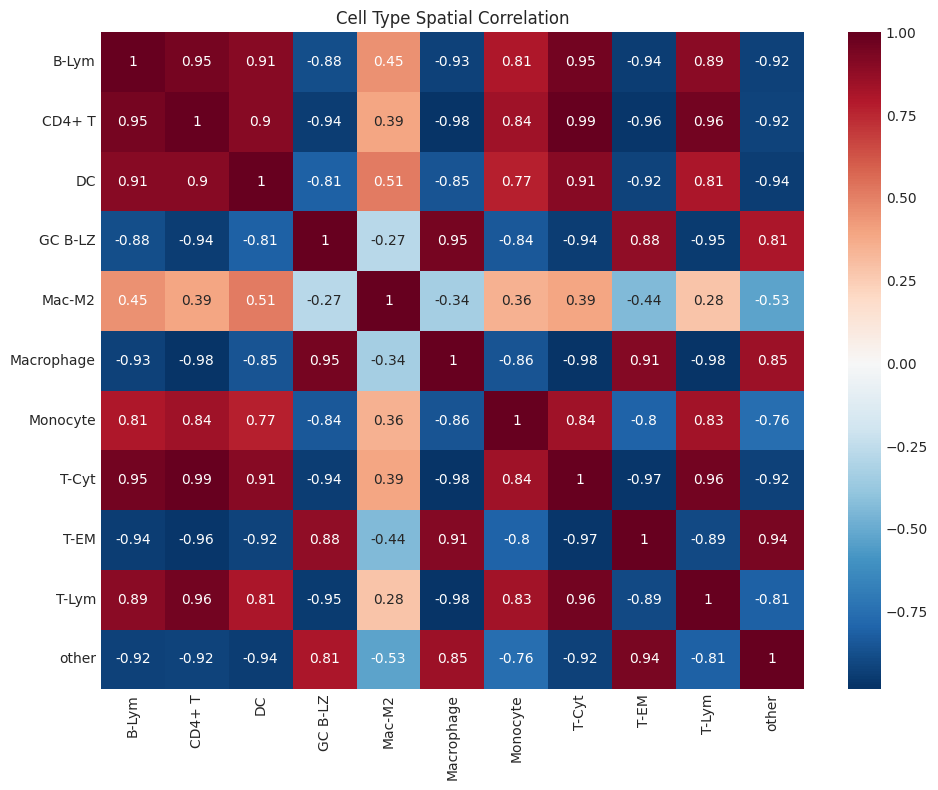

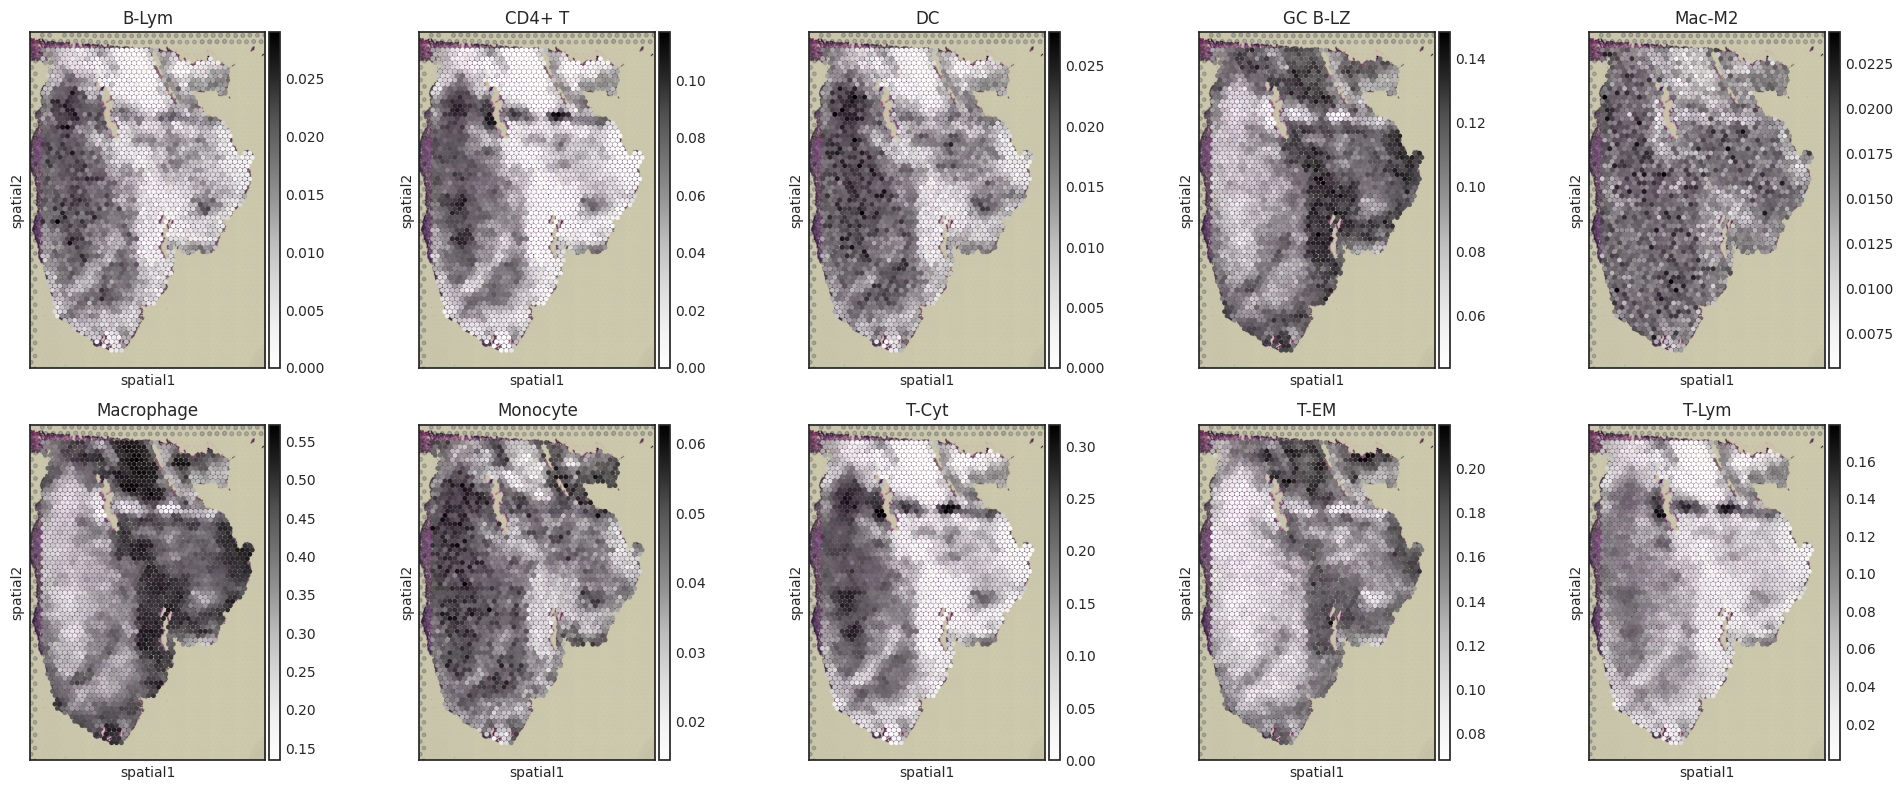

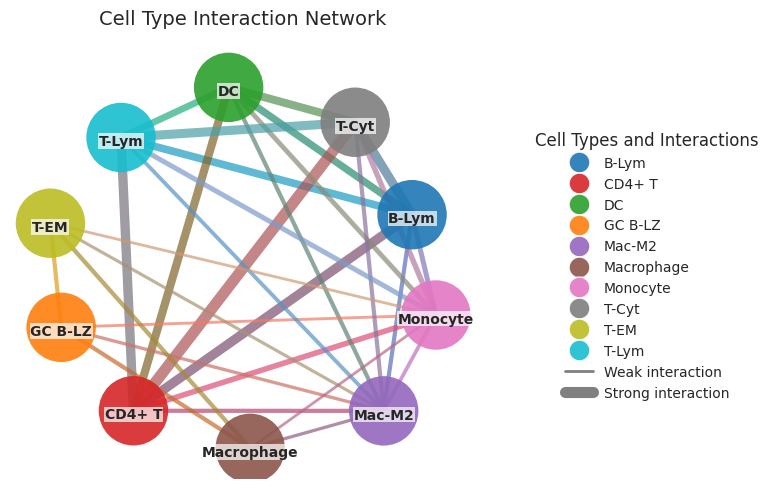

In [19]:
# 使用示例
results = spatial_analysis(adata)
# save_results(results)

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy import stats
import gseapy as gp
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def spatial_region_detection(adata, n_regions=5, use_highly_variable=True):
    """
   Using spatial coordinates to divide organizations into regions
    """

    spatial_coords = adata.obsm['spatial']
    
    # Using KMeans for regional partitioning
    kmeans = KMeans(n_clusters=n_regions, random_state=42)
    regions = kmeans.fit_predict(spatial_coords)
    
    # 将区域标签添加到adata对象，并设置为category类型
    adata.obs['spatial_region'] = pd.Categorical(regions)
    return adata

def differential_expression(adata, region):
   
    is_region = (adata.obs['spatial_region'] == region).astype(str)
    adata.obs['is_region'] = pd.Categorical(is_region)
 
    sc.tl.rank_genes_groups(adata, 'is_region', method='wilcoxon')
    
    de_results = pd.DataFrame({
        'gene': adata.uns['rank_genes_groups']['names']['True'],
        'pvals': adata.uns['rank_genes_groups']['pvals']['True'],
        'logfoldchanges': adata.uns['rank_genes_groups']['logfoldchanges']['True'],
    })
    
    return de_results

def pathway_enrichment(gene_list, organism='Human'):
    
    try:
        enr = gp.enrichr(gene_list=gene_list,
                        gene_sets=['KEGG_2021_Human'],
                        organism=organism,
                        outdir=None,
                        no_plot=True)
        return enr.results
    except Exception as e:
        print(f"Enrichment analysis error occurred: {str(e)}")
        return pd.DataFrame()

def spatial_pathway_analysis(adata, n_regions=5, p_cutoff=0.05, lfc_cutoff=1.0):
   
    print("Start regional division...")
    adata = spatial_region_detection(adata, n_regions)
  
    region_pathways = {}

    for region in range(n_regions):
        print(f"Analysis Area {region}...")
        try:

            de_results = differential_expression(adata, region)
            

            sig_genes = de_results[
                (de_results['pvals'] < p_cutoff) & 
                (abs(de_results['logfoldchanges']) > lfc_cutoff)
            ]['gene'].tolist()
            
            print(f"region {region} find {len(sig_genes)} Significant differentially expressed genes")
            
            if len(sig_genes) > 0:
                enrichment_results = pathway_enrichment(sig_genes)
                region_pathways[f'Region_{region}'] = enrichment_results
            else:
                print(f"region {region} No significant differentially expressed genes were found")
                
        except Exception as e:
            print(f"Processing area {region} error occurred: {str(e)}")
            continue
    
    return region_pathways

def save_enrichment_results(region_pathways, output_dir='enrichment_results'):
  
    os.makedirs(output_dir, exist_ok=True)

    excel_path = os.path.join(output_dir, f'enrichment_results.xlsx')
    with pd.ExcelWriter(excel_path) as writer:
       
        all_results = []
        
        for region, results in region_pathways.items():
            if len(results) > 0:
               
                results_with_region = results.copy()
                results_with_region['Region'] = region
                
                all_results.append(results_with_region)
                
                results.to_excel(writer, sheet_name=region.replace(':', '_'), index=False)
    
        if all_results:
            pd.concat(all_results, ignore_index=True).to_excel(
                writer, 
                sheet_name='All_Regions_Summary', 
                index=False
            )

        stats_data = {
            'Region': [],
            'Total_Pathways': [],
            'Significant_Pathways': [],
            'Top_Pathway': [],
            'Min_P_Value': []
        }
        
        for region, results in region_pathways.items():
            if len(results) > 0:
                stats_data['Region'].append(region)
                stats_data['Total_Pathways'].append(len(results))
                sig_pathways = len(results[results['Adjusted P-value'] < 0.05])
                stats_data['Significant_Pathways'].append(sig_pathways)
                stats_data['Top_Pathway'].append(results.iloc[0]['Term'] if len(results) > 0 else 'None')
                stats_data['Min_P_Value'].append(results['Adjusted P-value'].min() if len(results) > 0 else 'NA')
        
        pd.DataFrame(stats_data).to_excel(writer, sheet_name='Statistics', index=False)

    return excel_path

def visualize_enrichment(region_pathways, top_n=10):
   
    for region, results in region_pathways.items():
        if len(results) > 0:
         
            top_pathways = results.sort_values('Adjusted P-value').head(top_n)
            
          
            top_pathways['neglog10pval'] = -np.log10(top_pathways['Adjusted P-value'])
            
           
            plt.figure(figsize=(12, 6))
            sns.barplot(data=top_pathways, 
                       x='neglog10pval',
                       y='Term',
                       color='skyblue')
            
            plt.xlabel('-log10(Adjusted P-value)')
            plt.ylabel('Pathway')
            
            plt.title(f'Top {top_n} Enriched Pathways in {region}')
            plt.tight_layout()
            plt.show()

def main(adata, output_dir='/data/Data1/Data/human_brain_metastasis/result/enrichment_results'):
    
   
    print("Start data preprocessing...")

    if 'highly_variable' not in adata.var.columns:
        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata)
    
    print("Start spatial pathway analysis...")
  
    region_pathways = spatial_pathway_analysis(adata)
   
    if not any(len(results) > 0 for results in region_pathways.values()):
        print("Warning: No significantly enriched pathways found！")
        return region_pathways
    
    print("Start visualizing results...")
   
    visualize_enrichment(region_pathways)
    
    print("Save enrichment analysis results...")
 
    excel_path = save_enrichment_results(region_pathways, output_dir)
    
    return region_pathways, excel_path


"\n# 读取数据\nadata = sc.read_h5ad('your_data.h5ad')\n\n# 运行分析\nresults = main(adata)\n\n# 查看特定区域的富集结果\nprint(results['Region_0'].head())\n"

开始数据预处理...
开始空间通路分析...
开始区域划分...
分析区域 0...
区域 0 发现 41 个显著差异基因
分析区域 1...
区域 1 发现 79 个显著差异基因
分析区域 2...
区域 2 发现 938 个显著差异基因
分析区域 3...
区域 3 发现 22 个显著差异基因
分析区域 4...
区域 4 发现 130 个显著差异基因
开始结果可视化...


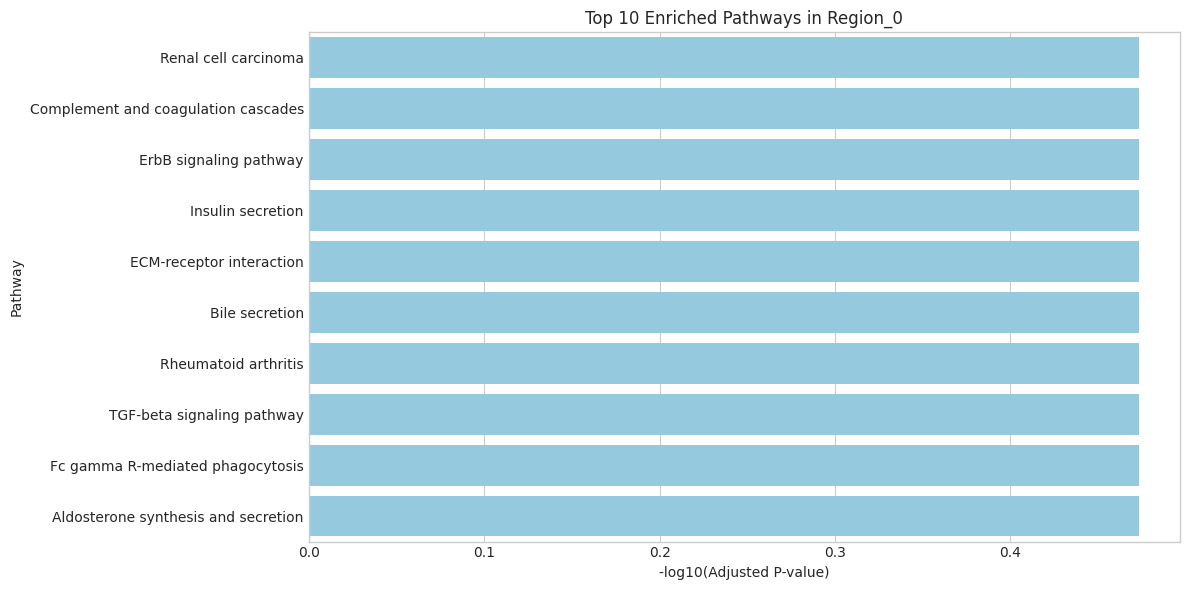

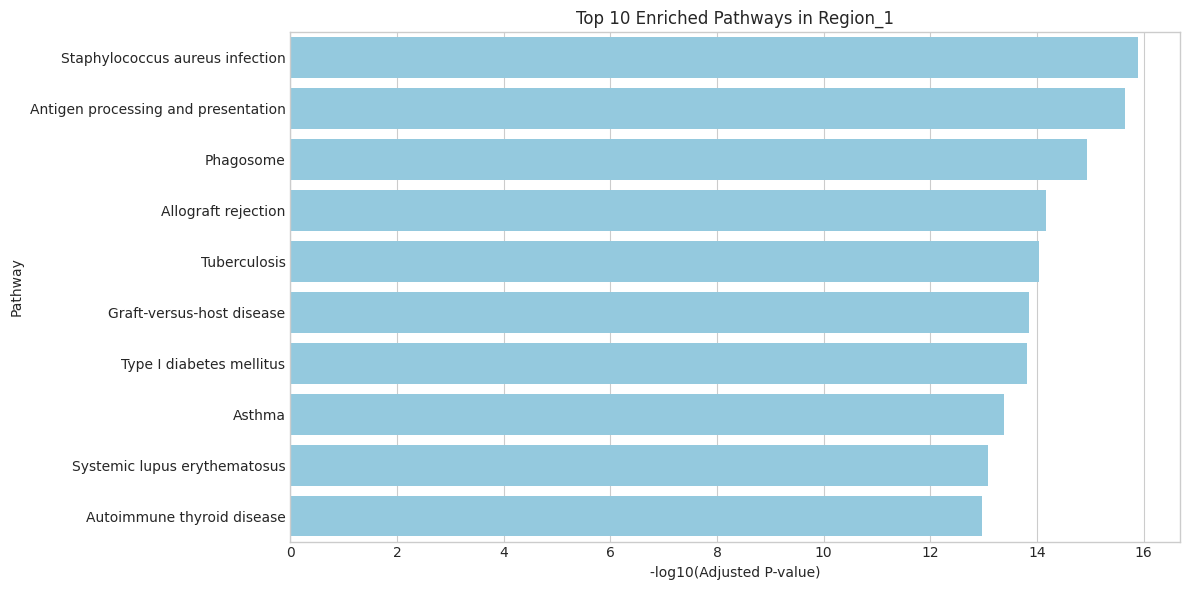

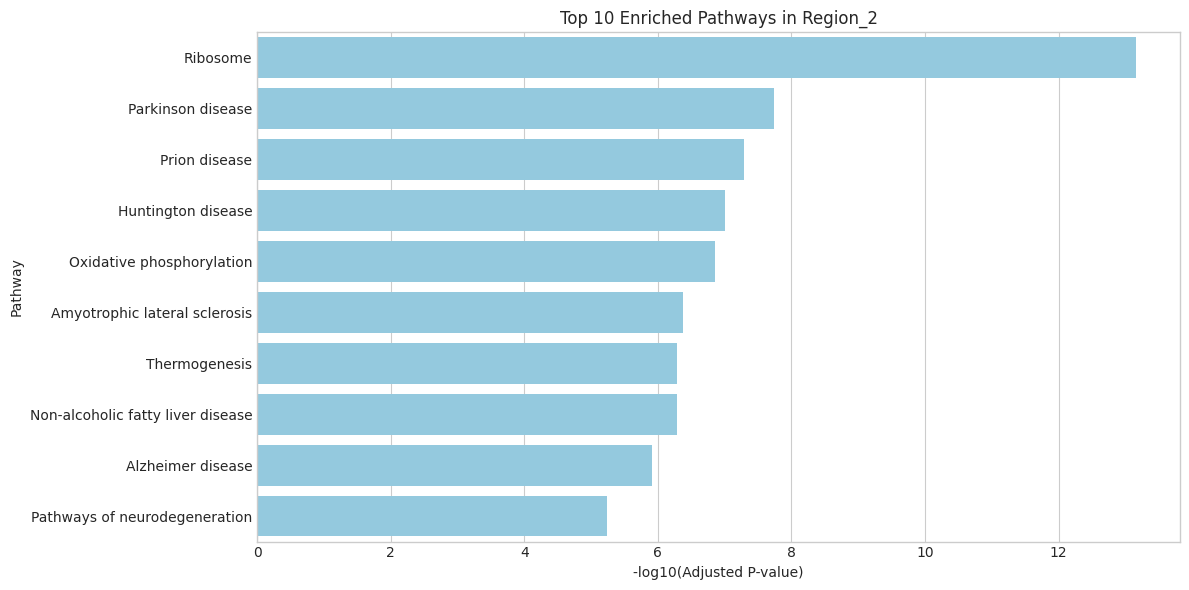

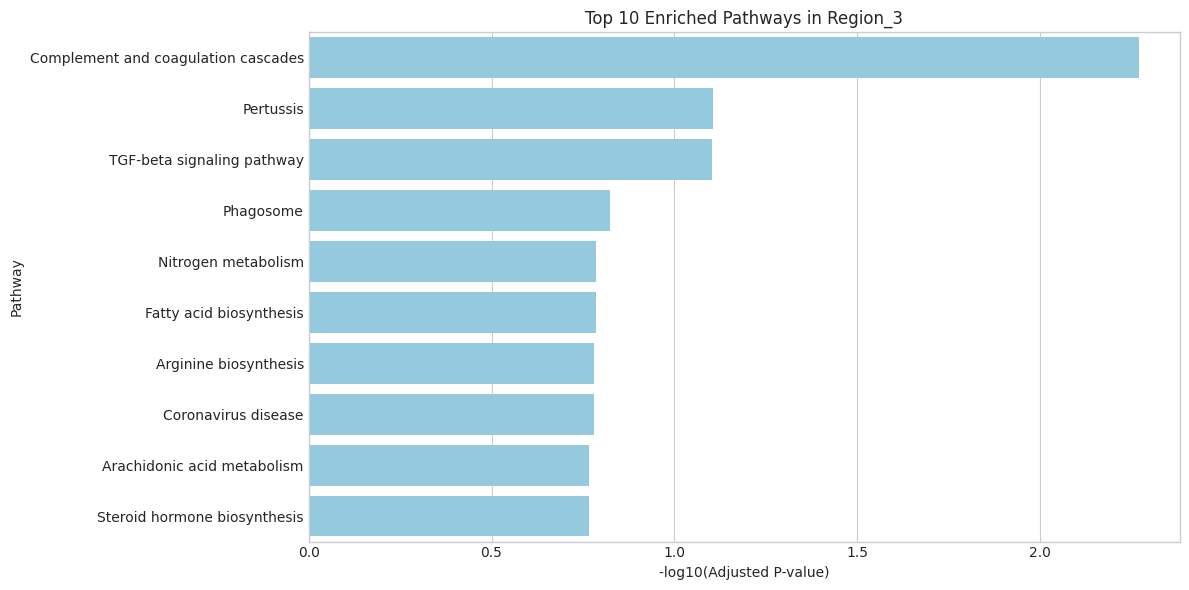

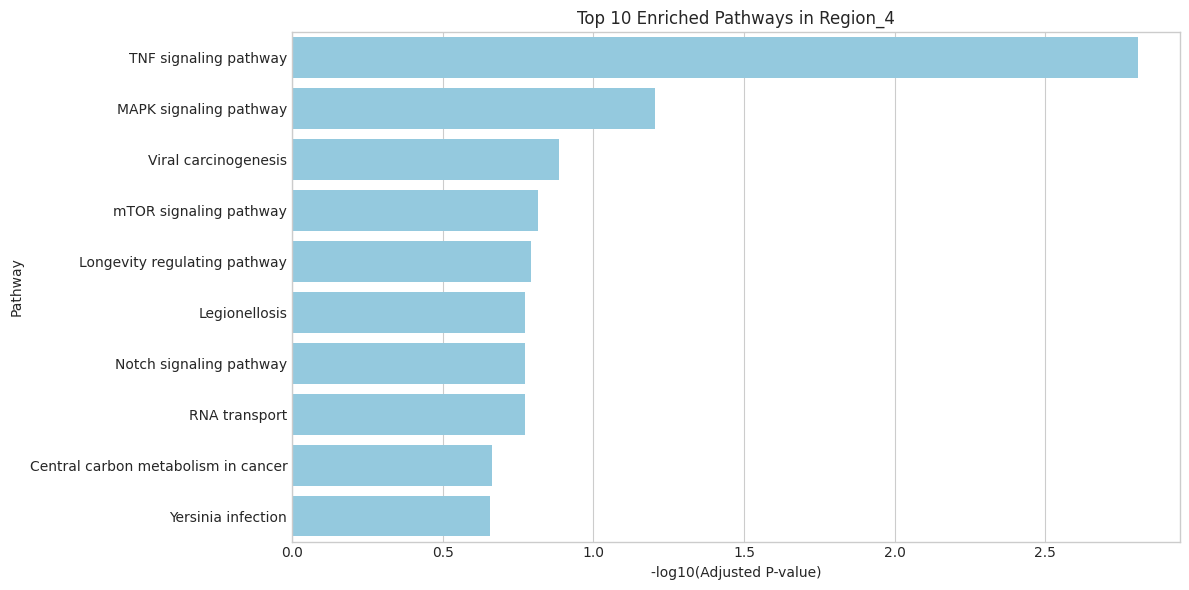

保存富集分析结果...


In [24]:
results = main(adata)